# Text Classification

In [17]:
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import classification_report
import sys
import zipfile
%matplotlib inline

In [18]:
sys.path.append('../..')

In [19]:
import common.load_data as data_helper
from text_classification_benchmarks.data_loader import clean_data, load_data
from text_classification_benchmarks.data_loader import remove_classes_with_too_few_examples, tokenize
from text_classification_benchmarks.metrics import perf_summary, print_perf_summary
from text_classification_benchmarks.metrics import perf_by_label, print_perf_by_label
from text_classification_benchmarks.metrics import plot_confusion_matrix, print_best_worst

## About the data

In [5]:
x, y, vocab, vocab_inv, df, labels = data_helper.load_crime_dataset()

INFO:root:Max sequence length: 14


In [20]:
train_df, val_df, test_df, classes = load_data()

Lengths Train: 5696, Val: 633, Test: 703, Classes: 191


### Tokens per utterance

In [21]:
train_df = tokenize(clean_data(train_df))

Length after cleaning data: 5695


In [22]:
train_df.head()

,label,utterance,tokens,length
0,111,Can you explain MMS charges for me while roaming?,"[Can, you, explain, MMS, charges, for, me, whi...",10
1,150,youre an idiott,"[you, re, an, idiott]",4
2,72,i am just making an enquiry today on the insto...,"[i, am, just, making, an, enquiry, today, on, ...",17
3,75,I dnt kno wat auto pay is,"[I, dnt, kno, wat, auto, pay, is]",7
4,92,I want to monthly recharge using my debit card,"[I, want, to, monthly, recharge, using, my, de...",9


In [23]:
# Min, Max, Mean, Std Dev. of tokens per utterance
lengths = train_df['length']
print('Min: {}, Max: {}, Mean: {}, Std: {}'
      .format(int(lengths.min()), int(lengths.max()), int(lengths.mean()), int(lengths.std())))

Min: 1, Max: 70, Mean: 12, Std: 8


In [24]:
char_lengths = train_df.utterance.apply(len)
char_lengths.mean(), char_lengths.max()

(56.633713784021069, 331)

In [25]:
# Variance, Std. Dev. of lengths by label
lengths_by_label = train_df.groupby(['label'])['length']
print('Mean Lengths by Label Variance: {}, Std: {}'
      .format(int(lengths_by_label.mean().var()), int(lengths_by_label.mean().std())))

Mean Lengths by Label Variance: 26, Std: 5


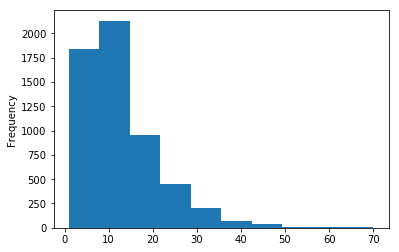

In [26]:
train_df['length'].plot.hist()

### Class Balance?

Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration.

In [27]:
counts_by_label = train_df.groupby('label').utterance.count()
print('Number Utterances by Label Min: {}, Max: {}, Mean: {}, Std: {}'
      .format(int(counts_by_label.min()), int(counts_by_label.max()), 
              int(counts_by_label.mean()), int(counts_by_label.std())))

Number Utterances by Label Min: 1, Max: 177, Mean: 29, Std: 26


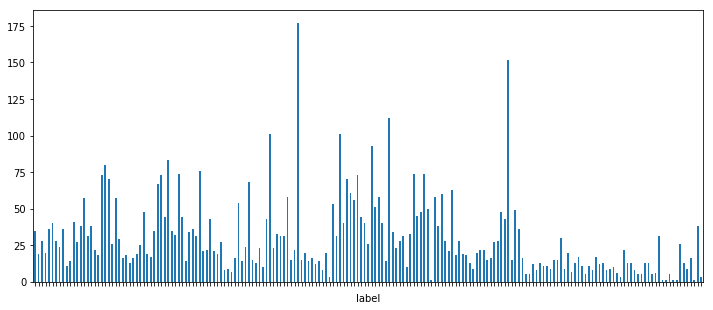

In [28]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
train_df.groupby('label').utterance.count().plot.bar(ylim=0)
ax.xaxis.set_major_formatter(plt.NullFormatter())  # hide labels

### Remove classes with too few examples

Necessary for later models.

In [29]:
train_df = remove_classes_with_too_few_examples(train_df, min_examples=6)

Length after processing data: 5645


In [30]:
print('Number classes after removal:', len(train_df.label.unique()))

Number classes after removal: 175


In [31]:
val_df = clean_data(val_df)

Length after cleaning data: 632


In [32]:
val_df.head()

,label,utterance
0,70,What is the customer number?
1,3,i want to update my contact details with telst...
2,47,I'm having trouble registering for Telstra air
3,21,I have been overcharged
4,108,"so change to post paid, and then my Mx plan is..."


In [33]:
val_df = remove_classes_with_too_few_examples(val_df, min_examples=6)

Length after processing data: 271


In [34]:
print('Lengths after removing labels with insufficient examples Train: {}, Val: {}'
      .format(len(train_df), len(val_df)))

Lengths after removing labels with insufficient examples Train: 5645, Val: 271


## Metrics

Options:
* ROC area under the curve
* AUC for a precision-recall curve (sklearn.metrics.average_precision_score)
* Generalize binary performance metrics such as precision, recall, and F1 to multi-class settings. Assuming a One-vs-All classifier, we can go with a "micro" average or a "macro" average.
* Multi-class log loss

In "micro averaging," we would calculate the performance, e.g., precision, from the individualtrue positives, true negatives, false positives, and false negatives of the the k-class model, e.g.:

    Precision_micro = (TP1 + ... + TPk) / (TP1 + ... + TPk + FP1 + ... + FPk)

And in macro-averaging, we would average the performances of each individual class, e.g.:

    Precision_macro = (P1 + ... + Pk) / k
    
Because the micro-average gives equal weight to each individual decision, large classes will dominate small ones. This makes it a measure of how effective your classifier is on the large classes in the collection.

On the other hand, macro-averaging gives equal weight to every class, and so will give you a sense of how effective you are on the small classes.

Notes:
* Classification Accuracy (or misclassification error) makes sense if your class labels are uniformly distributed. 

## Classical models

Bag-of-words features using TF-IDF.

In [17]:
from text_classification_benchmarks.tfidf_bow import generate_tfidf_features, show_relevant_terms

In [18]:
features, labels, tfidf, indices = generate_tfidf_features(train_df, val_df, cutoff=5, ngram_range=2)

In [19]:
print('Number Utterances: {}, Features: {}'.format(*features.shape))

Number Utterances: 5916, Features: 1387


*i* utterances represented by *j* features, representing the TF-IDF score for various unigrams and bigrams.

In [20]:
show_relevant_terms(features, labels, tfidf, classes, every=20)

Label: Account_Management-E_Close_Cancel_Account
	Most correlated unigrams: switching, shut, cancel
	Most correlated bigrams: phone internet, account credit, cancel service

Label: Billing-E_Bill_Explanation
	Most correlated unigrams: understand, charged, explain
	Most correlated bigrams: late fee, got email, don understand

Label: Complaints-T_Troubleshooting_Device
	Most correlated unigrams: samsung, fault, edge
	Most correlated bigrams: phone says, hi mobile, samsung s7

Label: Flow_Control-I_Need_More_Time
	Most correlated unigrams: try, ready, moment
	Most correlated bigrams: don know, try later, need time

Label: Information-T_Share_Data
	Most correlated unigrams: packs, shared, share
	Most correlated bigrams: add data, shared data, share data

Label: Service_Management-E_Add_Insurance
	Most correlated unigrams: stay, stayconnected, insurance
	Most correlated bigrams: pre paid, does work, stay connected

Label: Service_Management-T_Data_Share_SIM
	Most correlated unigrams: additi

### Logistic Regression

### Multinomial Naive Bayes Classifier

Naive Bayes is a family of algorithms based on applying Bayes theorem with a naive assumption,
that every feature is independent of the others, in order to predict the category of a given
sample. They are probabilistic classifiers, therefore will calculate the probability of each
category using Bayes theorem, and the category with the highest probability will be output.

Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses
a multinomial distribution for each of the features.

Multinomial Naive Bayes (MNB) is typically better at snippets than SVM models. ([Baselines and Bigrams: Simple, Good Sentiment
and Topic Classification; ACL 2012](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf))

In [21]:
from text_classification_benchmarks.multinomial_naive_bayes.model_setup import MultinomialNaiveBayesModel

In [135]:
X_train, y_train = train_df.utterance, train_df.label
X_val, y_val = val_df.utterance, val_df.label

In [23]:
model = MultinomialNaiveBayesModel(X_train, y_train)

In [24]:
def print_prediction(sample_idx):
    utterance = X_val[sample_idx]
    print('Utterance:', utterance)
    print('Actual:', classes[y_val[sample_idx]])
    print('Predicted:', classes[model.predict(utterance)])

In [25]:
samples = np.random.choice(X_val.index, size=10)
for i in samples:
    print_prediction(i)
    print()

Utterance: Hi I can't activate online it is playing up when it comes to a question with options
Actual: Complaints-T_Troubleshooting_Activation
Predicted: Information-T_Definitions

Utterance: explain my bill Summary
Actual: Billing-E_Bill_Explanation
Predicted: Billing-E_Bill_Explanation

Utterance: Hi. I am wanting to set up direct debit and am a concession card holder/pensioner. It says I could be exempt from the fee I think if so.
Actual: Payment-E_Recurring_Payment_Autopay
Predicted: Payment-E_Recurring_Payment_Autopay

Utterance: I don't want data
Actual: Flow_Control_Break_Flow-That_is_not_what_we_were_talking_about
Predicted: Service_Management-E_Add_Service_Features

Utterance: making telephone calls and texts from overseas
Actual: Service_Management-E_Roaming_Inquiry
Predicted: Service_Management-E_Roaming_Inquiry

Utterance: Have not received a credit
Actual: Billing-E_Dispute
Predicted: Complaints-T_Troubleshooting_Credit_or_Recharge

Utterance: Its only given me an extensi

In [26]:
y_pred = [model.predict(utterance) for utterance in X_val]

In [27]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.66
Recall (weighted avg)   : 0.54
F1 Score (weighted avg) : 0.51
Accuracy                : 0.54
ROC AUC (macro avg)     : 0.73


In [28]:
print_perf_by_label(perf_by_label(y_val, y_pred, classes, counts_by_label), rounded=2, sort_column='f1_score')

,name,idx,precision,recall,f1_score,roc_auc,support,n_examples
9,Complaints-T_Troubleshooting_Telstra_Air,47,0.90,1.00,0.95,1.00,9,76
6,Complaints-T_Troubleshooting_Broadband,36,0.88,0.88,0.88,0.94,8,73
8,Complaints-T_Troubleshooting_Email,41,1.00,0.75,0.86,0.88,8,74
12,Help-E_Connect_to_Agent,67,1.00,0.73,0.84,0.86,11,101
0,Account_Management-T_Telstra_Air_Login,14,0.83,0.83,0.83,0.91,6,57
18,Payment-E_Payment_History,90,1.00,0.71,0.83,0.86,7,61
28,Service_Management-T_Apple_Music,114,0.83,0.83,0.83,0.91,6,58
20,Payment-E_Recurring_Payment_Autopay,92,0.86,0.75,0.80,0.87,8,73
29,Service_Management-T_Carrier_Billing,116,1.00,0.57,0.73,0.79,7,60
26,Service_Management-E_Roaming_Inquiry,111,0.83,0.62,0.71,0.81,8,74


In [29]:
def print_classification_report(y_true, y_pred, classes):
    labels = np.unique(y_true)
    target_names = [classes[x] for x in labels]
    print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

In [30]:
print_classification_report(y_val, y_pred, classes)

                                                                precision    recall  f1-score   support

                        Account_Management-T_Telstra_Air_Login       0.83      0.83      0.83         6
                                     Billing-E_Balance_Inquiry       0.00      0.00      0.00         8
                                    Billing-E_Bill_Explanation       0.75      0.33      0.46         9
                                             Billing-E_Dispute       0.80      0.50      0.62         8
                                           Billing-T_Bill_Copy       1.00      0.33      0.50         6
                       Complaints-T_Troubleshooting_Activation       0.67      0.25      0.36         8
                        Complaints-T_Troubleshooting_Broadband       0.88      0.88      0.88         8
               Complaints-T_Troubleshooting_Credit_or_Recharge       0.50      0.67      0.57         9
                            Complaints-T_Troubleshooting_Email 

In [31]:
columns = ['model', 'precision_weighted_avg', 'recall_weighted_avg', 'f1_weighted_avg', 
           'accuracy', 'roc_auc', 'mean_latency']

In [32]:
mean_latency = round(model.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0008


In [33]:
data = dict({'model': 'Multinomial Naive Bayes', 'mean_latency': mean_latency}, **stats)
benchmarks = pd.DataFrame(data, columns=columns, index=[0])

In [34]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008


### One-vs-rest Multilabel Classifier (Logistic Regression)

In [109]:
import nlp.multilabel_classification as logreg

In [145]:
# importlib.reload(logreg)

<module 'nlp.multilabel_classification' from '../../nlp/multilabel_classification/__init__.py'>

In [136]:
test_df = clean_data(test_df)

Length after cleaning data: 703


In [137]:
X_test, y_test = test_df.utterance, test_df.label

In [146]:
y_train_multilabel = [[y] for y in y_train]
y_val_multilabel = [[y] for y in y_val]
y_val_predicted_labels_bow, y_val_predicted_labels_tfidf = \
    logreg.train_and_test(X_train.values.tolist(), y_train_multilabel,
                          X_val.values.tolist(), y_val_multilabel,
                          X_test.values.tolist(), dict_size=5000)

In [147]:
y_val_predicted_labels_bow = [x[0] if x else -1 for x in y_val_predicted_labels_bow]

In [148]:
stats = perf_summary(y_val, y_val_predicted_labels_bow)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.88
Recall (weighted avg)   : 0.35
F1 Score (weighted avg) : 0.48
Accuracy                : 0.35
ROC AUC (macro avg)     : 0.67


In [149]:
y_val_predicted_labels_tfidf = [x[0] if x else -1 for x in y_val_predicted_labels_tfidf]

In [150]:
stats = perf_summary(y_val, y_val_predicted_labels_tfidf)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.8
Recall (weighted avg)   : 0.25
F1 Score (weighted avg) : 0.35
Accuracy                : 0.25
ROC AUC (macro avg)     : 0.62


Good precision but too many unlabelled predictions.

**TODO:** evaluate performance against any label in multilabel set

## Try multiple model types

1. Random Forest
2. Multinomimal Naive Bayes
3. Logistic Regression
4. Linear Support Vector Machine

In [35]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

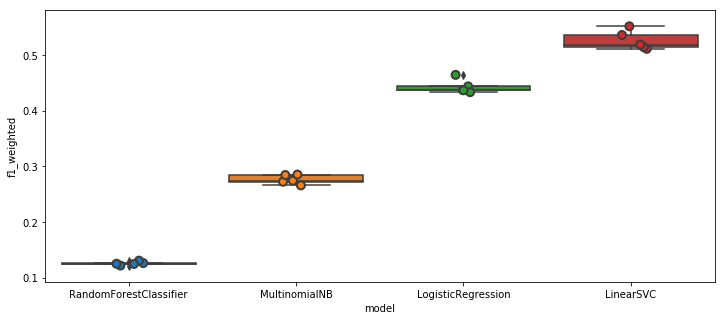

In [36]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LinearSVC()
]

CV = 5  # number of folds in a (Stratified) KFold
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model', 'fold_idx', 'f1_weighted'])

fig = plt.figure(figsize=(12, 5))
sns.boxplot(x='model', y='f1_weighted', data=cv_df)
sns.stripplot(x='model', y='f1_weighted', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [37]:
cv_df.groupby('model').f1_weighted.mean()

model
LinearSVC                 0.526594
LogisticRegression        0.443169
MultinomialNB             0.276464
RandomForestClassifier    0.125507
Name: f1_weighted, dtype: float64

LinearSVC is the pick. Lets continue with that...

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = \
    train_test_split(features, labels, indices, test_size=0.33, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

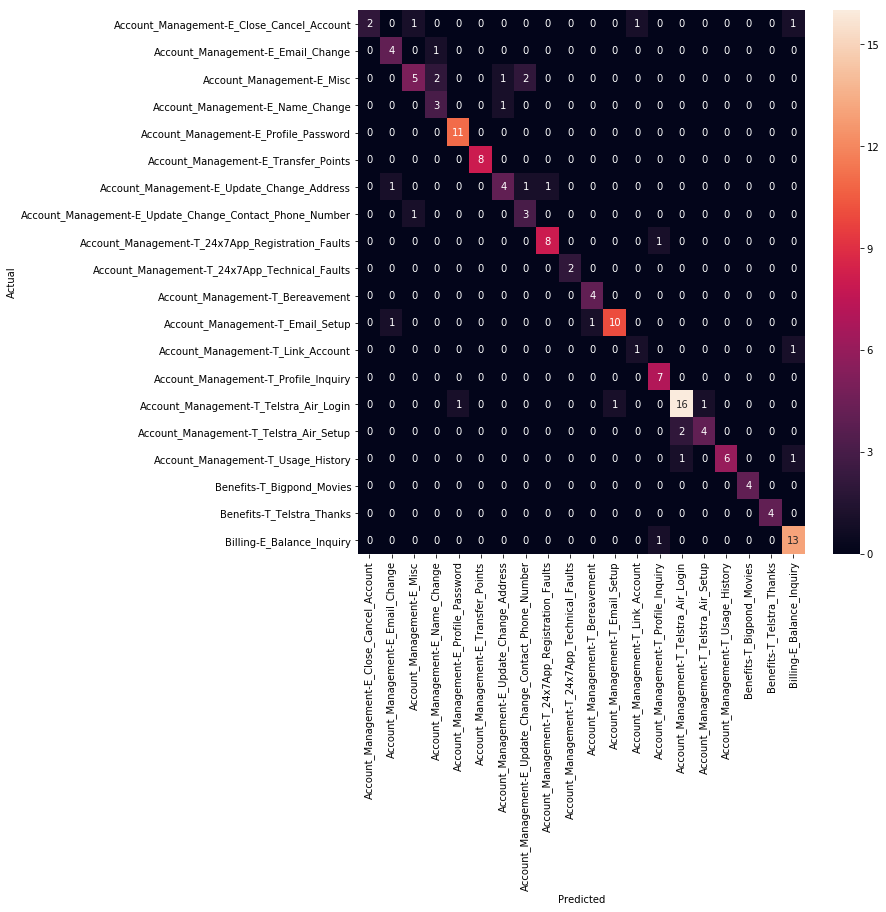

In [40]:
plot_confusion_matrix(y_test, y_pred, classes, 0, 20)

In [41]:
print_perf_summary(perf_summary(y_test, y_pred), rounded=2)

Precision (weighted avg): 0.53
Recall (weighted avg)   : 0.5
F1 Score (weighted avg) : 0.49
Accuracy                : 0.5
ROC AUC (macro avg)     : 0.72


In [42]:
stats = perf_by_label(y_test, y_pred, classes, counts_by_label)
print_perf_by_label(stats, rounded=2, sort_column='f1_score')

,name,idx,precision,recall,f1_score,roc_auc,support,n_examples
46,Complaints-T_Troubleshooting_Speed,46,1.00,0.90,0.95,0.95,10,31
51,Device_Management-T_SIM_PIN,51,1.00,0.83,0.91,0.92,6,21
120,Service_Management-T_Foxtel,122,0.83,1.00,0.91,1.00,5,19
112,Service_Management-T_Apple_Music,114,0.86,0.95,0.90,0.97,19,58
42,Complaints-T_Troubleshooting_Landline,42,0.76,1.00,0.87,1.00,13,44
47,Complaints-T_Troubleshooting_Telstra_Air,47,0.82,0.92,0.87,0.96,25,76
138,TEMP_ChitChat-Are_you_kidding,142,1.00,0.75,0.86,0.88,4,12
4,Account_Management-E_Profile_Password,4,0.85,0.85,0.85,0.92,13,36
118,Service_Management-T_Data_Share_SIM,120,0.83,0.83,0.83,0.92,6,18
144,TEMP_ChitChat-I_am_sorry,148,1.00,0.71,0.83,0.86,7,15


In [43]:
print_classification_report(y_test, y_pred, classes)

                                                                precision    recall  f1-score   support

                     Account_Management-E_Close_Cancel_Account       0.29      0.20      0.24        10
                             Account_Management-E_Email_Change       0.67      0.40      0.50        10
                                     Account_Management-E_Misc       0.45      0.50      0.48        10
                              Account_Management-E_Name_Change       0.50      0.60      0.55         5
                         Account_Management-E_Profile_Password       0.85      0.85      0.85        13
                          Account_Management-E_Transfer_Points       0.57      0.89      0.70         9
                    Account_Management-E_Update_Change_Address       0.50      0.40      0.44        10
       Account_Management-E_Update_Change_Contact_Phone_Number       0.43      0.75      0.55         4
              Account_Management-T_24x7App_Registration_Faults 

In [44]:
print_best_worst(stats, rounded=2, sort_column='f1_score', top_n=5, max_name_len=35)

name                                 idx    precision    recall    f1_score    roc_auc    support    n_examples
-----------------------------------  -----  -----------  --------  ----------  ---------  ---------  ------------
Best 5:
Complaints-T_Troubleshooting_Speed   46     1.0          0.9       0.95        0.95       10         31
Device_Management-T_SIM_PIN          51     1.0          0.83      0.91        0.92       6          21
Service_Management-T_Foxtel          122    0.83         1.0       0.91        1.0        5          19
Service_Management-T_Apple_Music     114    0.86         0.95      0.9         0.97       19         58
Complaints-T_Troubleshooting_Landli  42     0.76         1.0       0.87        1.0        13         44

Worst 5:
Complaints-T_Troubleshooting_Roamin  45     0.25         0.11      0.15        0.55       18         36
Service_Management-E_De_Activate_Pr  103    0.2          0.12      0.15        0.56       8          23
Off_Topic-T_Out_of_Scope    

The reported averages are a prevalence-weighted macro-average across classes (equivalent to precision_recall_fscore_support with average='weighted').

## NB-SVM -  SVM with NB features

A simple but novel SVM variant using NB log-count ratios as feature values.

By combining generative and discriminative classifiers, we present a simple model variant where an SVM is built over NB log-count ratios as feature values, and show that it is a strong and robust performer over all the presented tasks.

Otherwise identical to the SVM, except we use x(k) = ˜f^(k), where ˜f(k) = ˆr ◦ ˆf(k) is the elementwise product. While this does very well for long documents, we find that an interpolation between MNB and SVM performs excellently for all documents and we report results using this model:

    w' = (1 − β)w¯ + βw

where w¯ = ||w||1 / |V| is the mean magnitude of w, and β ∈ [0, 1] is the interpolation parameter. This interpolation can be seen as a form of regularization: trust NB unless the SVM is very confident.

While (Ng and Jordan, 2002) showed that NB is better than SVM/logistic regression (LR) with few training cases, we show that MNB is also better with short documents. In contrast to their result that an SVM usually beats NB when it has more than 30–50 training cases, we show that MNB is still better on snippets even with relatively large training sets (9k cases).

In [151]:
import text_classification_benchmarks.nbsvm as nbsvm

In [156]:
# import text_classification_benchmarks.nbsvm.model_setup

In [157]:
# importlib.reload(text_classification_benchmarks.nbsvm.model_setup)

<module 'text_classification_benchmarks.nbsvm.model_setup' from '../../text_classification_benchmarks/nbsvm/model_setup.py'>

In [158]:
# importlib.reload(nbsvm)

<module 'text_classification_benchmarks.nbsvm' from '../../text_classification_benchmarks/nbsvm/__init__.py'>

In [159]:
preds, model = nbsvm.train_and_test(train_df, val_df)

Vectorizing...
ngram_range: (1, 3)
Fitting...
Classifying...


In [154]:
stats = perf_summary(val_df.label, preds)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.74
Recall (weighted avg)   : 0.6
F1 Score (weighted avg) : 0.65
Accuracy                : 0.6
ROC AUC (macro avg)     : 0.79


In [160]:
mean_latency = round(model.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.3411


In [161]:
data = dict({'model': 'NBSVM', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [162]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010
2,IBM Watson,0.857916,0.686347,0.751115,0.686347,0.837539,0.1462
3,Google Dialogflow,0.804371,0.690037,0.732270,0.690037,0.838199,0.5415
4,Microsoft LUIS,0.762499,0.619926,0.672307,0.619926,0.804848,1.2942
5,Amazon Lex,0.712986,0.572864,0.619189,0.572864,0.775990,0.3801
6,NBSVM,0.741484,0.597786,0.648603,0.597786,0.786707,0.3411


# Open Source Options

## RASA NLU

In [45]:
from text_classification_benchmarks.api_services.rasa_service import create_import_file, RasaService

### Create RASA NLU Training Set

In [46]:
# create_import_file(train_df, classes)

### Call RASA NLU API Service

In [47]:
max_api_calls = 500

In [48]:
rasa_service = RasaService('./models/current/nlu', classes, max_api_calls=max_api_calls, verbose=False)

INFO:tensorflow:Restoring parameters from ./models/current/nlu/intent_classifier_tensorflow_embedding.ckpt


In [49]:
y_pred = rasa_service.predict_batch(val_df)

In [262]:
y_val = val_df.label.values

In [51]:
stats = perf_summary(y_val[:max_api_calls + 1], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.79
Recall (weighted avg)   : 0.63
F1 Score (weighted avg) : 0.68
Accuracy                : 0.63
ROC AUC (macro avg)     : 0.8


In [52]:
mean_latency = round(rasa_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.001


In [53]:
data = dict({'model': 'RASA NLU', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [54]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010


# Commercial Options

## IBM Watson

In [55]:
from text_classification_benchmarks.api_services.watson_service import create_import_file, WatsonService

### Create Import File

In [56]:
# create_import_file(train_df, classes)

### Call Watson API Service

In [57]:
%env VAULT_TOKEN=4hn3XkC0ia8Lt37dn7EvBxwv

env: VAULT_TOKEN=4hn3XkC0ia8Lt37dn7EvBxwv


In [58]:
watson_service = WatsonService(classes, max_api_calls=max_api_calls, verbose=False)

In [59]:
y_pred = watson_service.predict_batch(val_df)

In [60]:
stats = perf_summary(y_val[:max_api_calls + 1], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.86
Recall (weighted avg)   : 0.69
F1 Score (weighted avg) : 0.75
Accuracy                : 0.69
ROC AUC (macro avg)     : 0.84


In [61]:
mean_latency = round(watson_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.1462


In [62]:
data = dict({'model': 'IBM Watson', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [63]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010
2,IBM Watson,0.857916,0.686347,0.751115,0.686347,0.837539,0.1462


## Google Dialogflow

In [72]:
import text_classification_benchmarks.api_services.dialogflow_service as dialogflow
from text_classification_benchmarks.api_services.dialogflow_service import create_import_file, DialogflowService

In [71]:
# importlib.reload(dialogflow)

<module 'text_classification_benchmarks.api_services.dialogflow_service' from '../../text_classification_benchmarks/api_services/dialogflow_service.py'>

### Create Import File

In [65]:
# create_import_file(train_df, classes, output_path='./import')

### Call Dialogflow API Service

In [73]:
dialogflow_service = dialogflow.DialogflowService(classes, max_api_calls=max_api_calls, verbose=False)

In [74]:
y_pred = dialogflow_service.predict_batch(val_df)

In [75]:
stats = perf_summary(y_val[:max_api_calls + 1], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.8
Recall (weighted avg)   : 0.69
F1 Score (weighted avg) : 0.73
Accuracy                : 0.69
ROC AUC (macro avg)     : 0.84


In [76]:
mean_latency = round(dialogflow_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.5415


In [77]:
data = dict({'model': 'Google Dialogflow', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [78]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010
2,IBM Watson,0.857916,0.686347,0.751115,0.686347,0.837539,0.1462
3,Google Dialogflow,0.804371,0.690037,0.732270,0.690037,0.838199,0.5415


## Microsoft LUIS

In [80]:
import text_classification_benchmarks.api_services.luis_service as luis
from text_classification_benchmarks.api_services.luis_service import create_import_file, LuisService

In [ ]:
# importlib.reload(luis)

In [83]:
# luis_service = luis.LuisService(classes.tolist(), max_api_calls=5, verbose=True)

In [84]:
# y_pred = luis_service.predict_batch(val_df)

### Create Training Set

In [ ]:
# create_import_file(train_df, classes)

### Call LUIS Service

In [85]:
luis_service = LuisService(classes, max_api_calls=max_api_calls, verbose=False)

In [86]:
y_pred = luis_service.predict_batch(val_df)

In [87]:
stats = perf_summary(y_val[:max_api_calls + 1], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.76
Recall (weighted avg)   : 0.62
F1 Score (weighted avg) : 0.67
Accuracy                : 0.62
ROC AUC (macro avg)     : 0.8


In [88]:
mean_latency = round(luis_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 1.2942


In [89]:
data = dict({'model': 'Microsoft LUIS', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [90]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010
2,IBM Watson,0.857916,0.686347,0.751115,0.686347,0.837539,0.1462
3,Google Dialogflow,0.804371,0.690037,0.732270,0.690037,0.838199,0.5415
4,Microsoft LUIS,0.762499,0.619926,0.672307,0.619926,0.804848,1.2942


## Amazon Lex

In [98]:
import text_classification_benchmarks.api_services.lex_service as lex
from text_classification_benchmarks.api_services.lex_service import create_import_file, LexService

In [102]:
# importlib.reload(lex)

### Create Training Set

In [92]:
# create_import_file(train_df, classes, output_path='./lex_import')

### Call Lex API Service

In [100]:
lex_service = lex.LexService('intent_test', 'Prod', classes, max_api_calls=max_api_calls, verbose=False)

In [101]:
y_pred = lex_service.predict_batch(val_df)

In [103]:
y_val = list(filter(lambda x: x < 100, val_df.label))

In [104]:
stats = perf_summary(y_val[:max_api_calls + 1], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.71
Recall (weighted avg)   : 0.57
F1 Score (weighted avg) : 0.62
Accuracy                : 0.57
ROC AUC (macro avg)     : 0.78


In [105]:
mean_latency = round(lex_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.3801


In [106]:
data = dict({'model': 'Amazon Lex', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

## fastText

[Bag of Tricks for Efficient Text Classification](https://arxiv.org/pdf/1607.01759.pdf)

NOTE: This does not use the fastText embeddings. It is their classification model.

Recently, models based on neural networks have become increasingly popular (Kim, 2014; Zhang and LeCun, 2015; Conneau et al., 2016). While these models achieve very good performance in practice, they tend to be relatively slow both at train and test time, limiting their use on very large datasets.

A simple and efficient baseline for sentence classification is to represent sentences as bag of words (BoW) and train a linear classifier, e.g., a logistic regression or an SVM (Joachims, 1998; Fan et al., 2008). However, linear classifiers do not share parameters among features and classes. This possibly limits their generalization in the context of large output space where some classes have very few examples. Common solutions to this problem are to factorize the linear classifier into low rank matrices (Schutze, 1992; Mikolov et al., 2013) or to use multilayer neural networks (Collobert and Weston, 2008; Zhang et al., 2015).

Hierarchical Softmax

When the number of classes is large, computing the linear classifier is computationally expensive. More precisely, the computational complexity is `O(kh)` where `k` is the number of classes and `h` the dimension of the text representation. In order to improve our running time, we use a hierarchical softmax (Goodman, 2001) based on the Huffman coding tree (Mikolov et al., 2013). During training, the computational complexity drops to `O(h log2(k))`.

Model architecture of a fastText for a sentence with `N` ngram features `x1, ...xn`. The features are embedded and averaged to calculate the hidden variable.

This architecture is similar to the CBOW model of Mikolov et al. (2013), where the middle word is replaced by a label. We use the softmax function `f` to compute the probability distribution over the predefined classes. Cross entropy is used to compute loss. As bag-of-word representation does not consider word order, n-gram features is used to capture some partial information about the local word order.

In [321]:
import fastText as ft

### Bigrams

In [322]:
model = ft.load_model('../fasttext/classifier.ftz')

In [336]:
y_pred = []
for i, utterance in enumerate(val_df.utterance.values):
    label = model.predict(utterance)
    y_pred.append(classes.tolist().index(label[0][0][9:]))

In [338]:
y_val = val_df.label

In [343]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.92
Recall (weighted avg)   : 0.83
F1 Score (weighted avg) : 0.86
Accuracy                : 0.83
ROC AUC (macro avg)     : 0.91


In [344]:
y_pred_test = []
for i, utterance in enumerate(test_df.utterance.values):
    label = model.predict(utterance)
    y_pred_test.append(classes.tolist().index(label[0][0][9:]))

In [345]:
y_test = test_df.label

In [346]:
stats = perf_summary(y_test, y_pred_test)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.72
Recall (weighted avg)   : 0.73
F1 Score (weighted avg) : 0.7
Accuracy                : 0.73
ROC AUC (macro avg)     : 0.86


In [347]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010
2,IBM Watson,0.857916,0.686347,0.751115,0.686347,0.837539,0.1462
3,Google Dialogflow,0.804371,0.690037,0.732270,0.690037,0.838199,0.5415
4,Microsoft LUIS,0.762499,0.619926,0.672307,0.619926,0.804848,1.2942
5,Amazon Lex,0.712986,0.572864,0.619189,0.572864,0.775990,0.3801
6,NBSVM,0.741484,0.597786,0.648603,0.597786,0.786707,0.3411


### Trigrams

In [349]:
model = ft.load_model('../fasttext/classifier.ftz')

In [350]:
y_pred = []
for i, utterance in enumerate(val_df.utterance.values):
    label = model.predict(utterance)
    y_pred.append(classes.tolist().index(label[0][0][9:]))

In [351]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.94
Recall (weighted avg)   : 0.85
F1 Score (weighted avg) : 0.88
Accuracy                : 0.85
ROC AUC (macro avg)     : 0.92


In [352]:
y_pred_test = []
for i, utterance in enumerate(test_df.utterance.values):
    label = model.predict(utterance)
    y_pred_test.append(classes.tolist().index(label[0][0][9:]))

In [353]:
stats = perf_summary(y_test, y_pred_test)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.72
Recall (weighted avg)   : 0.72
F1 Score (weighted avg) : 0.7
Accuracy                : 0.72
ROC AUC (macro avg)     : 0.86


# Deep Learning Models

## Word-level CNN (Kim 2014)

CNNs have become a modern standard baseline method akin to Naive Bayes models, Support Vector Machine (SVMs) and logistic regression.

Originally invented for computer vision, CNN models have subsequently been shown to be effective
for NLP and have achieved excellent results in semantic parsing (Yih et al., 2014), search query
retrieval (Shen et al., 2014), sentence modeling (Kalchbrenner et al., 2014), and other traditional
NLP tasks (Collobert et al., 2011).

The first layers embeds words into low-dimensional vectors. The next layer performs convolutions over
the embedded word vectors using multiple filter sizes. For example, sliding over 3, 4 or 5 words at a
time. Next, we max-pool the result of the convolutional layer into a long feature vector, add dropout
regularization, and classify the result using a softmax layer.

See [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf).

In [35]:
from tensorflow.contrib import learn
import text_classification_benchmarks.word_cnn.util as util

In [361]:
checkpoint_dir = '../word_cnn/runs/1540695350/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [362]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [363]:
x_raw = val_df.utterance.values
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [365]:
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1540695350/checkpoints/model-17800


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1540695350/checkpoints/model-17800


In [41]:
y_val = val_df.label.values

In [367]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.74
Recall (weighted avg)   : 0.59
F1 Score (weighted avg) : 0.64
Accuracy                : 0.59
ROC AUC (macro avg)     : 0.79


## Word-level CNN initialised with Word2Vec embeddings

Trains the above CNN initialised with word vectors obtained from an unsupervised neural language
model. These vectors were trained by Mikolov et al. (2013) on 100 billion words of Google News.
The vectors have dimensionality of 300 and were trained using the continuous bag-of-words
architecture.

We keep the word vectors static and learn only the other parameters of the model.

In [36]:
checkpoint_dir = '../word_cnn/runs/1541065783/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [37]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [38]:
x_raw = val_df.utterance.values
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [39]:
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541065783/checkpoints/model-17800


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541065783/checkpoints/model-17800


In [42]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.77
Recall (weighted avg)   : 0.62
F1 Score (weighted avg) : 0.67
Accuracy                : 0.62
ROC AUC (macro avg)     : 0.8


A little bit better.

See also [A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1510.03820.pdf).

### With L2 regularization

In [43]:
checkpoint_dir = '../word_cnn/runs/1541112212/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [44]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [45]:
x_raw = val_df.utterance.values
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [46]:
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541112212/checkpoints/model-8900


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541112212/checkpoints/model-8900


In [47]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.77
Recall (weighted avg)   : 0.6
F1 Score (weighted avg) : 0.66
Accuracy                : 0.6
ROC AUC (macro avg)     : 0.79


### With higher dropout rate (keep_prob = 0.25)

In [48]:
checkpoint_dir = '../word_cnn/runs/1541241817/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [49]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [50]:
x_raw = val_df.utterance.values
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [51]:
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541241817/checkpoints/model-8900


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541241817/checkpoints/model-8900


In [52]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.81
Recall (weighted avg)   : 0.69
F1 Score (weighted avg) : 0.73
Accuracy                : 0.69
ROC AUC (macro avg)     : 0.84


## Character-level CNN (Kim et al. 2015)

[Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

Character-level ConvNet is an effective method for text classification without the need for words.

Historically, ConvNets usually require large-scale datasets to work. In this case, it appears to be competitive on our small dataset.

ConvNets may work well for user-generated data. Further analysis is needed to validate the
hypothesis that ConvNets are truly good at identifying exotic character combinations such as
misspellings and emoticons.

In [232]:
import text_classification_benchmarks.char_cnn.model_setup as setup
import text_classification_benchmarks.char_cnn.util as util

Using TensorFlow backend.


In [313]:
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"\/\\|_@#$%^&*~`+-=<>()[]{}"
input_size = 400
n_classes = len(classes)
x_val = val_df.utterance.values
y_val = val_df.label.values

In [314]:
val_data = util.Data(x_val, y_val, alphabet, input_size, n_classes)
val_data.load_data()
x_val_, y_val_ = val_data.get_all_data()

In [315]:
model = setup.CharCNN(input_size,
                      alphabet_size=69,
                      embedding_size=128,
                      conv_layers=[[256, 10], [256, 7], [256, 5], [256, 3]],
                      fully_connected_layers=[1024, 1024],
                      n_classes=n_classes,
                      keep_prob=0.1,
                      model_filename='../char_cnn/models/weights.best.hdf5',
                      optimizer='adam',
                      loss='categorical_crossentropy')

Loading model at ../char_cnn/models/weights.best.hdf5
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sent_input (InputLayer)          (None, 400)           0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 400, 128)      8960        sent_input[0][0]                 
____________________________________________________________________________________________________
Conv1D_256_10 (Conv1D)           (None, 391, 256)      327936      embedding_4[0][0]                
____________________________________________________________________________________________________
Conv1D_256_7 (Conv1D)            (None, 394, 256)      229632      embedding_4[0][0]                
_____________________________________

In [316]:
preds = model.predict(x_val_, batch_size=128)

In [317]:
y_pred = np.argmax(preds, axis=1) + 1

In [318]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.81
Recall (weighted avg)   : 0.66
F1 Score (weighted avg) : 0.72
Accuracy                : 0.66
ROC AUC (macro avg)     : 0.83


In [319]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010
2,IBM Watson,0.857916,0.686347,0.751115,0.686347,0.837539,0.1462
3,Google Dialogflow,0.804371,0.690037,0.732270,0.690037,0.838199,0.5415
4,Microsoft LUIS,0.762499,0.619926,0.672307,0.619926,0.804848,1.2942
5,Amazon Lex,0.712986,0.572864,0.619189,0.572864,0.775990,0.3801
6,NBSVM,0.741484,0.597786,0.648603,0.597786,0.786707,0.3411


## Bidirectional LSTM (Recurrent Neural Network)

In [168]:
import text_classification_benchmarks.bi_lstm.util as util

In [196]:
# importlib.reload(util)

<module 'text_classification_benchmarks.bi_lstm.util' from '../../text_classification_benchmarks/bi_lstm/util.py'>

In [193]:
# Show warnings and errors only
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [197]:
train_labels, train_utterances, train_lengths = util.prepare_data(train_df)
val_labels, val_utterances, val_lengths = util.prepare_data(val_df)
x_train, y_train, train_lengths, x_val, y_val, val_lengths, max_length, vocab_size, _ = \
    util.process_data(train_labels, train_utterances, train_lengths, 
                      val_labels, val_utterances, val_lengths, min_frequency=0)

In [203]:
# Training performance
y_pred = util.test(x_train, y_train, train_lengths, batch_size=64, run_dir='../bi_lstm/', checkpoint='clf-8000')

INFO:tensorflow:Restoring parameters from ../bi_lstm/model/clf-8000
Test accuracy: 0.9643793708898805


In [206]:
# Test performance
y_pred = util.test(x_val, y_val, val_lengths, batch_size=64, run_dir='../bi_lstm/', checkpoint='clf-8000')

INFO:tensorflow:Restoring parameters from ../bi_lstm/model/clf-8000
Test accuracy: 0.7398437559604645


Looks like overfitting. Need a more data!

But look, **no feature engineering!**

In [207]:
stats = perf_summary(y_val, y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.77
Recall (weighted avg)   : 0.59
F1 Score (weighted avg) : 0.65
Accuracy                : 0.59
ROC AUC (macro avg)     : 0.79


## Combined CNN and RNN

In [219]:
import common.load_data as load_data
import common.util as data_util
import tf_model.text_classifier.util as util

In [227]:
# importlib.reload(load_data)
# importlib.reload(data_util)

In [221]:
x, y, vocab, vocab_inv, df, labels = \
    load_data.prepare_classification_training_set(train_df, selected=['label', 'utterance'])

INFO:root:Max sequence length: 62


In [229]:
constants = {
    'batch_size': 128,
    'keep_prob': 0.5,
    'emb_dim': 300,
    'eval_every': 500,
    'filter_sizes': [3, 4, 5],
    'n_hidden': 300,
    'l2_reg_lambda': 0.0,
    'max_pool_size': 4,
    'non_static': False,
    'n_epochs': 1000,
    'n_filters': 32,
    'learning_rate': 0.001,
    'decay': 0.9
}
util.train(x, y, vocab, vocab_inv, labels, constants)

INFO:root:x_train: 4572, x_val: 508, x_test: 565
INFO:root:y_train: 4572, y_val: 508, y_test: 565
INFO:root:Accuracy on val set: 0.23031496062992127
CRITICAL:root:Saved model checkpoints_1540096722/model-500 at step 500
CRITICAL:root:Best accuracy 0.23031496062992127 at step 500
INFO:root:Accuracy on val set: 0.3838582677165354
CRITICAL:root:Saved model checkpoints_1540096722/model-1000 at step 1000
CRITICAL:root:Best accuracy 0.3838582677165354 at step 1000
INFO:root:Accuracy on val set: 0.4311023622047244
CRITICAL:root:Saved model checkpoints_1540096722/model-1500 at step 1500
CRITICAL:root:Best accuracy 0.4311023622047244 at step 1500
INFO:root:Accuracy on val set: 0.4389763779527559
CRITICAL:root:Saved model checkpoints_1540096722/model-2000 at step 2000
CRITICAL:root:Best accuracy 0.4389763779527559 at step 2000
INFO:root:Accuracy on val set: 0.4547244094488189
CRITICAL:root:Saved model checkpoints_1540096722/model-2500 at step 2500
CRITICAL:root:Best accuracy 0.4547244094488189 a

KeyboardInterrupt: 

# Rankings

In [107]:
benchmarks.sort_values('f1_weighted_avg', ascending=False)

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
2,IBM Watson,0.857916,0.686347,0.751115,0.686347,0.837539,0.1462
3,Google Dialogflow,0.804371,0.690037,0.732270,0.690037,0.838199,0.5415
1,RASA NLU,0.785428,0.630996,0.682865,0.630996,0.804886,0.0010
4,Microsoft LUIS,0.762499,0.619926,0.672307,0.619926,0.804848,1.2942
5,Amazon Lex,0.712986,0.572864,0.619189,0.572864,0.775990,0.3801
0,Multinomial Naive Bayes,0.656506,0.542435,0.514728,0.542435,0.733035,0.0008


Notes:

* IBM API straightforward
* Google documentation poor, e.g. session ID as hard-coded value not mentioned, API formats not documented - had to refer to export as sample
* Microsoft - complex setup: need to assign resource groups from Azure, lacking error details on JSON response - unhelpful messages such as "Bad Format" for a large JSON input, annoying limits such as 50 char limit on intent names and utterance text, (max limits on number of intents, etc. have been increased though)
* Amazon Lex - The number of intents exceeds the permissible value. A bot can have a maximum of 100 intents. This bot has 175. Slow import process. Intent names only alpha + underscores. Utterance length limited to 200. Issues with a few duplicate utterances. Build failed - "The rate of requests exceeds the throughput limit. Retry the request." UI update issues on latest Chrome. Some save operations strangely slow. Doesn't accept numbers. "An utterance can consist only of Unicode characters, spaces, and valid punctuation marks. Valid punctuation marks are: periods for abbreviations, underscores, apostrophes, and hyphens." - However, doesn't accept examples with underscores or apostrophes.

# Approaches

Conventional:
* SVM for domain/intent classification
* CRF for slot filling

Deep learning:
* LSTM for domain/intent classification and slot filling

Multinominal Naive Bayes is better at snippets. MNB is normally better and more stable than multivariate Bernoulli NB, and binarized MNB is better than standard MNB.

SVM is better at full-length reviews.

NBSVM: a simple but novel SVM variant using NB log-count ratios as feature values consistently performs well across tasks and datasets.

[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](http://www.aclweb.org/anthology/P12-2018)

# Conclusions

Dataset size forms a dichotomy between traditional and ConvNets models. The most obvious trend 
coming from all the plots in figure 3 is that the larger datasets tend to perform better. 
Traditional methods like n-grams TFIDF remain strong candidates for dataset of size up to 
several hundreds of thousands, and only until the dataset goes to the scale of several millions 
do we observe that character-level ConvNets start to do better.

### TODO

* Check performance against utterance length
* Training time